In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
import warnings
import featuretools as ft
warnings.filterwarnings('ignore') #忽略警告


In [2]:
train = pd.read_csv('./data/titanic/train.csv',dtype={"Age": np.float64}) #dtype是指定欄位資料的型態 此邊是Age欄的資料型態是float64
test = pd.read_csv('./data/titanic/test.csv',dtype={"Age": np.float64})
submit = pd.read_csv('./data/titanic/gender_submission.csv')
PassengerId=test['PassengerId'] #把測試集的乘客ID記錄下來

In [3]:
#接下來合併train,test data 以利資料觀察、清洗
data=train.append(test) #合併

data.reset_index(inplace=True,drop=True)
#############################################################################
## 不reset的話原本的train,test的index合併後不會重新排序                       #
## https://www.twblogs.net/a/5c21eb8abd9eee16b3dae800                       #   
## drop=True: 把原來的索引index列去掉，丟掉。                                 #  
## drop=False:保留原來的索引（以前的可能是亂的)                                #     
## 修改一個對象時：                                                          #
##      inplace=True：不創建新的對象，直接對原始對象進行修改；                  #
##      inplace=False：對數據進行修改，創建並返回新的對象承載其修改結果。        #
############################################################################  
data.info()
data.describe()
data.head()

#由資料的資訊可知總量1309筆，其中Age,Cabin,Embarked,Survived有遺漏值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


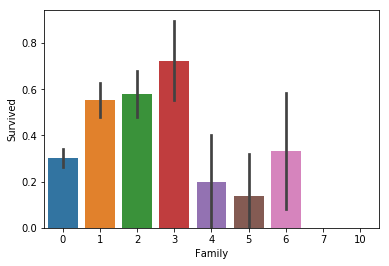

In [4]:
#由上述觀察可知 家人數量對於存活率是一樣的影響 越少越容易死亡 因此合併起來計算
data['Family']=data['Parch']+data['SibSp']
sns.barplot(y=data['Survived'],x=data['Family'])

In [5]:
#Embarked少一值用最多的S填補，Fare用平均值填補
data['Embarked']=data['Embarked'].fillna('S')
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

In [6]:
#cabin遺漏值最多 因此空值補NoCabin，並將資料一般化到第一個字母
data["Cabin"] = data['Cabin'].apply(lambda x : str(x)[0] if not pd.isnull(x) else 'NoCabin')
data["Cabin"].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [7]:
#ticket 一般化到前面字母，可能代表位置，後面編號刪除
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.replace(".","").replace("/","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [8]:
#Name一般化成 稱謂
data['Title1']=data['Name'].str.split(",",expand=True)[1]
data['Name'].str.split(",",expand=True).head(3)
data['Title1'].head(3)

0                                Mr. Owen Harris
1     Mrs. John Bradley (Florence Briggs Thayer)
2                                    Miss. Laina
Name: Title1, dtype: object

In [9]:
data['Title1']=data['Title1'].str.split(".",expand=True)[0]
data['Title1'].head(3)

0       Mr
1      Mrs
2     Miss
Name: Title1, dtype: object

In [10]:
data['Title1'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [11]:
#簡化稱謂 刪掉少數的
data['Title2'] = data['Title1'].replace(
    {'Mlle':'Miss','Mme':'Mrs','Ms':'Miss','Dr':'Mr','Major':'Mr','Lady':'Mrs','the Countess':'Mrs','Jonkheer':'Mr','Col':'Mr','Rev':'Mr','Capt':'Mr','Sir':'Mr','Don':'Mr','Dona':'Mrs'})


In [12]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [13]:
data['Title2'] = data['Title1'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
    ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs'           ,'Mr'      ,'Mr' ,'Mr' ,'Mr'  ,'Mr' ,'Mr' ,'Mrs'])

In [14]:
data['Title2'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer', ' Dona'], dtype=object)

In [15]:
#類別資料轉數值資料
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title1'] = data['Title1'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes

In [16]:
data.drop(['Ticket','SibSp','Parch','Name','Title1'],axis=1,inplace=True)
data.head()

,Age,Cabin,Embarked,Fare,PassengerId,Pclass,Sex,Survived,Family,Ticket_info,Title2
0,22.0,7,2,7.2500,1,2,1,0.0,1,2,12
1,38.0,2,0,71.2833,2,0,0,1.0,1,14,13
2,26.0,7,2,7.9250,3,2,0,1.0,0,31,9
3,35.0,2,2,53.1000,4,0,0,1.0,1,36,13
4,35.0,7,2,8.0500,5,2,1,0.0,0,36,12


In [17]:
#年齡的填補用隨機森林來預測值
dataAgeNull = data[data["Age"].isnull()]
dataAgeNotNull = data[data["Age"].notnull()]
remove_outlier = dataAgeNotNull[(np.abs(dataAgeNotNull["Fare"]-dataAgeNotNull["Fare"].mean())>(4*dataAgeNotNull["Fare"].std()))|
                      (np.abs(dataAgeNotNull["Family"]-dataAgeNotNull["Family"].mean())>(4*dataAgeNotNull["Family"].std()))                     
                     ]
rfModel_age = RandomForestRegressor(n_estimators=2000,random_state=42)
ageColumns = ['Embarked', 'Fare', 'Pclass', 'Sex', 'Family',  'Title2','Cabin','Ticket_info']
rfModel_age.fit(remove_outlier[ageColumns], remove_outlier["Age"])

ageNullValues = rfModel_age.predict(X= dataAgeNull[ageColumns])
dataAgeNull.loc[:,"Age"] = ageNullValues
data = dataAgeNull.append(dataAgeNotNull)
data.reset_index(inplace=True, drop=True)

In [18]:
es = ft.EntitySet(id = 'Id') 
# adding a dataframe 
es.entity_from_dataframe(entity_id = 'titanic', 
                         dataframe = data, 
                         index = 'PassengerId')

Entityset: Id
  Entities:
    titanic [Rows: 1309, Columns: 11]
  Relationships:
    No relationships

In [19]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity = 'titanic', 
                                       max_depth = 2, 
                                       verbose = 1, 
                                       n_jobs = 3)

Built 10 features
EntitySet scattered to workers in 2.156 seconds
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████████████████████████████████████| Calculated: 11/11 chunks


In [22]:
feature_matrix = feature_matrix.reindex(index=data.index) 
feature_matrix = feature_matrix.reset_index()

In [28]:
feature_matrix.columns

Index(['index', 'PassengerId', 'Age', 'Cabin', 'Embarked', 'Fare', 'Pclass',
       'Sex', 'Survived', 'Family', 'Ticket_info', 'Title2'],
      dtype='object')

In [23]:
#進行隨機森林預測生存率
dataTrain = feature_matrix[pd.notnull(feature_matrix['Survived'])].sort_values(by=["PassengerId"])
dataTest = feature_matrix[~pd.notnull(feature_matrix['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns

Index(['index', 'PassengerId', 'Age', 'Cabin', 'Embarked', 'Fare', 'Pclass',
       'Sex', 'Survived', 'Family', 'Ticket_info', 'Title2'],
      dtype='object')

In [24]:
dataTrain = dataTrain[['Survived', 'Age', 'Embarked', 'Fare',  'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTest = dataTest[['Age', 'Embarked', 'Fare', 'Pclass', 'Sex', 'Family', 'Title2','Ticket_info','Cabin']]
dataTrain

,Survived,Age,Embarked,Fare,Pclass,Sex,Family,Title2,Ticket_info,Cabin
1,1.0,38.000000,0.0,71.2833,0.0,0.0,1.0,13.0,14.0,2.0
2,1.0,26.000000,2.0,7.9250,2.0,0.0,0.0,9.0,31.0,7.0
3,1.0,35.000000,2.0,53.1000,0.0,0.0,1.0,13.0,36.0,2.0
4,0.0,35.000000,2.0,8.0500,2.0,1.0,0.0,12.0,36.0,7.0
5,0.0,41.188763,1.0,8.4583,2.0,1.0,0.0,12.0,36.0,7.0
6,0.0,54.000000,2.0,51.8625,0.0,1.0,0.0,12.0,36.0,4.0
7,0.0,2.000000,2.0,21.0750,2.0,1.0,4.0,8.0,36.0,7.0
8,1.0,27.000000,2.0,11.1333,2.0,0.0,2.0,13.0,36.0,7.0
9,1.0,14.000000,0.0,30.0708,1.0,0.0,1.0,13.0,36.0,7.0
10,1.0,4.000000,2.0,16.7000,2.0,0.0,2.0,9.0,15.0,6.0


In [25]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=12,
                             min_samples_leaf=1,
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(dataTrain.iloc[:, 1:], dataTrain.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8247


In [26]:
pd.concat((pd.DataFrame(dataTrain.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

,variable,importance
4,Sex,0.275065
2,Fare,0.162950
6,Title2,0.144345
0,Age,0.135892
3,Pclass,0.087589
5,Family,0.071730
8,Cabin,0.067229
7,Ticket_info,0.030889
1,Embarked,0.024309


In [27]:
rf_res =  rf.predict(dataTest)
submit['Survived'] = rf_res
submit['Survived'] = submit['Survived'].astype(int)
submit.to_csv('submit_Tita_Auto.csv', index= False)
submit

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').